# Вишнева Ольга Леонидовна, @dominoVIII

# Определение жанра по изображению обложки музыкального диска

## Основная задача

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

## Данные

Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

## Метрика

Метрики для классификации: Accuracy, Precision, Recall, F1. Можно предложить свои метрики как часть исследования.

In [ ]:
#!pip install fastai

In [2]:
!pip install faiss-cpu --no-cache

In [3]:
import os
import pandas as pd
import faiss

import pickle

from sklearn.metrics import classification_report

from fastai.vision.all import *
from fastai.metrics import accuracy
from PIL import Image

import torch
from torchvision import transforms
from torchvision.models import resnet34, resnet50

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH = '/content/drive/MyDrive/Covers'

In [6]:
SEED = 239

In [7]:
data = []

# Используем os.walk для обхода файлов и папок
for folder_path, _, files in os.walk(PATH):
    folder_name = os.path.relpath(folder_path, PATH)
    for file_name in files:
        data.append((folder_name, file_name))

# Создание DataFrame
df = pd.DataFrame(data, columns=['cover_genre', 'cover_title'])
print(df)

     cover_genre                               cover_title
0          anime  e4c8f983-f5dd-4954-8756-309f397c678a.png
1          anime  d5ed1bc7-5fc9-4f30-a5c6-09eb78e1ae45.png
2          anime  39ddb231-ae6b-48b3-924f-10b77a0a2246.png
3          anime  9e08d548-30e0-42cd-b2af-df4d5104f681.png
4          anime  59fadb87-c515-490a-bb3a-0e84b6a915be.png
...          ...                                       ...
7802      reggae  6b8b0fbf-07ba-46a1-9ca1-2b21b24ecb7b.png
7803      reggae  22c6f2d7-9540-4b57-8a49-aa7c955ed93e.png
7804      reggae  f2d70ba8-cb8b-4bcd-bcd8-ba963b608564.png
7805      reggae  741b3743-d21b-4eea-b353-6444ce1f9a9f.png
7806      reggae  ba61bf29-3e77-48dc-9354-e0fa3015841f.png

[7807 rows x 2 columns]


## Первая часть (построение baseline модели)

In [ ]:
# Сформируем эмбеддинги всех изображений
# Результаты прогона всех изображений собираем в массиве embeddings
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

#image_genre_mapping = {}
embeddings = []

for root, dirs, files in os.walk(PATH):
    for file_name in files:
        if file_name.endswith('.jpg') or file_name.endswith('.png'):
            img = Image.open(os.path.join(root, file_name))
            img = img.convert('RGB')
            img_tensor = transform(img).unsqueeze(0)
            with torch.no_grad():
                embedding = model(img_tensor)
                embeddings.append(embedding.squeeze().numpy())
                #image_genre_mapping[file_name] = df[df['cover_title'] == file_name]['cover_genre'].values[0]


# Сохранение эмбеддингов в файл с помощью pickle
with open('/content/drive/MyDrive/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [ ]:
# Загружаем эмбеддинги изображений
with open('/content/drive/MyDrive/embeddings.pkl', 'rb') as f:
    embeddings_loaded = pickle.load(f)

embeddings = embeddings_loaded
#embeddings

[array([0.03015499, 1.5665498 , 0.        , ..., 0.22601937, 0.11282502,
        0.05077452], dtype=float32),
 array([0.03589543, 0.3996314 , 1.886352  , ..., 0.15372567, 0.69174975,
        0.9546908 ], dtype=float32),
 array([0.23277816, 0.53663623, 1.3235703 , ..., 0.50496805, 0.24630469,
        0.19696224], dtype=float32),
 array([0.12066592, 0.03965159, 0.07071318, ..., 0.00326145, 0.00218983,
        0.10093733], dtype=float32),
 array([0.2516433 , 2.2708972 , 0.5374338 , ..., 0.16332603, 0.0529572 ,
        0.38493338], dtype=float32),
 array([0.27256194, 1.848348  , 0.35438257, ..., 0.19925098, 0.07695954,
        0.02150496], dtype=float32),
 array([0.02333468, 0.26668027, 0.3506785 , ..., 0.01930237, 0.07807393,
        0.11721641], dtype=float32),
 array([0.34494454, 0.52414614, 0.39907965, ..., 0.45831493, 0.8151436 ,
        0.33549374], dtype=float32),
 array([0.02051477, 0.54575264, 0.6091962 , ..., 0.862879  , 0.18278216,
        0.34883374], dtype=float32),
 array([0.

In [ ]:
# Добавление эмбеддингов в датафрейм
df['embeddings'] = embeddings
df.head()

,cover_genre,cover_title,embeddings
0,anime,e4c8f983-f5dd-4954-8756-309f397c678a.png,"[0.030154988, 1.5665498, 0.0, 0.004510174, 0.32221913, 0.054129966, 0.0, 0.0011332218, 0.6437103, 0.0014897691, 0.69956386, 0.37589997, 0.33245784, 0.15299022, 0.10632382, 0.012427657, 0.11907692, 0.13420856, 0.40834224, 0.60376364, 0.8884639, 0.11511467, 0.00085218926, 0.15554792, 0.963633, 0.53313386, 0.43893608, 0.2092648, 0.08276167, 0.08441872, 0.6528455, 1.1925575, 0.009411584, 0.43140864, 1.5549769, 0.026224129, 0.3456336, 0.38288528, 0.3392825, 1.1684383, 0.15344365, 0.4615656, 0.7406912, 0.028462304, 0.09877999, 0.3372536, 0.3368698, 0.4244596, 0.19965589, 0.12668437, 0.010967632,..."
1,anime,d5ed1bc7-5fc9-4f30-a5c6-09eb78e1ae45.png,"[0.03589543, 0.3996314, 1.886352, 0.6401261, 0.76775885, 0.3821183, 0.24359049, 0.009332066, 0.6945289, 0.5746282, 0.13465942, 0.63999987, 0.064333275, 0.37517965, 0.07517643, 0.5556724, 0.42675936, 0.6308573, 0.9120025, 0.23926231, 0.36928117, 0.39023995, 0.5777226, 0.5286711, 0.4845347, 0.47761536, 0.4378072, 0.3278334, 0.47906092, 0.26082146, 0.24902071, 0.77841413, 0.13121837, 1.0371972, 0.38549587, 0.96122617, 0.27241844, 0.8543876, 0.59167486, 0.99959344, 0.14200579, 1.0626374, 0.14839712, 0.12060608, 0.53727335, 0.21030948, 0.3520412, 1.753328, 0.99629265, 0.45651135, 0.11613618, 0...."
2,anime,39ddb231-ae6b-48b3-924f-10b77a0a2246.png,"[0.23277816, 0.53663623, 1.3235703, 0.23560338, 0.5171063, 0.27777457, 0.0011146214, 0.0017591888, 0.5360107, 0.3763587, 0.33019194, 0.016584031, 0.10743081, 0.04140201, 0.03567519, 0.6064694, 0.060928594, 0.031022899, 0.3677833, 1.1551609, 1.9114462, 0.081206806, 0.34835193, 0.034190003, 1.1709944, 0.09718438, 0.10256904, 0.5691661, 0.0649842, 0.24604024, 0.5116443, 1.252838, 0.39348108, 0.29981503, 1.1632925, 0.25924993, 0.22909361, 0.50781816, 0.5295543, 0.23620878, 0.059032, 1.6136479, 0.7496594, 0.41718328, 0.03931986, 0.2887104, 0.30924973, 0.820679, 0.72234935, 0.07124851, 0.5727925..."
3,anime,9e08d548-30e0-42cd-b2af-df4d5104f681.png,"[0.12066592, 0.039651588, 0.070713185, 0.35450312, 0.19715945, 0.29988313, 0.0361782, 0.01115253, 0.65536857, 0.19638851, 0.2768992, 0.87747926, 0.9439278, 0.35712805, 0.0019663237, 0.27675417, 0.3625114, 1.2014573, 0.08086657, 0.2755372, 0.72955936, 0.0658393, 0.088526, 0.69734806, 0.14879367, 0.20217843, 0.24446203, 0.54989314, 0.379102, 0.17244421, 0.89247996, 0.74258983, 0.038694806, 1.5825713, 1.3109351, 0.083450474, 0.15125461, 0.37426874, 0.5115565, 0.6950951, 0.3601793, 0.45491037, 0.50999755, 0.10219754, 0.33713228, 0.42098057, 0.392234, 0.8801971, 0.54010427, 0.86993456, 0.178833..."
4,anime,59fadb87-c515-490a-bb3a-0e84b6a915be.png,"[0.2516433, 2.2708972, 0.5374338, 0.21707349, 0.42309162, 0.37918082, 0.5048978, 0.7834071, 0.52027744, 1.0680935, 0.2806276, 1.2684052, 0.08132346, 0.12681268, 0.16892847, 0.07529517, 0.23608066, 0.75169134, 0.47135738, 0.5102335, 0.54517114, 0.082491115, 0.21474703, 0.2631391, 0.9816676, 0.25392905, 0.21731529, 0.28471777, 0.70955706, 0.1647799, 1.0484073, 1.4726121, 0.16151491, 0.5713644, 0.5531591, 0.5012523, 0.34843564, 0.6723298, 0.77754915, 0.49392712, 0.84559447, 0.64226156, 0.85272247, 0.023019817, 0.52770865, 0.33527604, 0.18293928, 1.722535, 0.18841965, 1.0240381, 0.18898371, 0...."


In [ ]:
# Создание индекса FAISS
d = df['embeddings'].iloc[0].shape[0]  # Размерность эмбеддинга
index = faiss.IndexFlatL2(d)  # Создание плоского индекса L2

In [ ]:
# Добавление эмбеддингов в индекс
embeddings = np.vstack(df['embeddings'].to_numpy())  # Преобразование эмбеддингов из датафрейма в массив numpy
index.add(embeddings)

In [ ]:
# Классификация для всех записей из датафрейма (k-means)
predicted_classes = []

for i in range(len(df)):
    query_embedding = df['embeddings'].iloc[i]  # Получение эмбеддинга для текущей записи
    query_embedding = query_embedding.reshape(1, -1)  # Преобразование в форму, подходящую для поиска

    # Поиск ближайших соседей для текущего эмбеддинга
    k = 5  # Количество ближайших соседей
    D, I = index.search(query_embedding, k)  # Поиск ближайших соседей

    # Определение класса изображения на основе классов его ближайших соседей
    nearest_neighbors_classes = df.iloc[I[0]]['cover_genre']  # Получение классов ближайших соседей
    predicted_class = nearest_neighbors_classes.mode()[0]  # Определение наиболее частого класса среди ближайших соседей
    predicted_classes.append(predicted_class)


# Добавление предсказанных классов в датафрейм
df['predicted_genre'] = predicted_classes
df.head()

,cover_genre,cover_title,embeddings,predicted_genre
0,anime,e4c8f983-f5dd-4954-8756-309f397c678a.png,"[0.030154988, 1.5665498, 0.0, 0.004510174, 0.32221913, 0.054129966, 0.0, 0.0011332218, 0.6437103, 0.0014897691, 0.69956386, 0.37589997, 0.33245784, 0.15299022, 0.10632382, 0.012427657, 0.11907692, 0.13420856, 0.40834224, 0.60376364, 0.8884639, 0.11511467, 0.00085218926, 0.15554792, 0.963633, 0.53313386, 0.43893608, 0.2092648, 0.08276167, 0.08441872, 0.6528455, 1.1925575, 0.009411584, 0.43140864, 1.5549769, 0.026224129, 0.3456336, 0.38288528, 0.3392825, 1.1684383, 0.15344365, 0.4615656, 0.7406912, 0.028462304, 0.09877999, 0.3372536, 0.3368698, 0.4244596, 0.19965589, 0.12668437, 0.010967632,...",anime
1,anime,d5ed1bc7-5fc9-4f30-a5c6-09eb78e1ae45.png,"[0.03589543, 0.3996314, 1.886352, 0.6401261, 0.76775885, 0.3821183, 0.24359049, 0.009332066, 0.6945289, 0.5746282, 0.13465942, 0.63999987, 0.064333275, 0.37517965, 0.07517643, 0.5556724, 0.42675936, 0.6308573, 0.9120025, 0.23926231, 0.36928117, 0.39023995, 0.5777226, 0.5286711, 0.4845347, 0.47761536, 0.4378072, 0.3278334, 0.47906092, 0.26082146, 0.24902071, 0.77841413, 0.13121837, 1.0371972, 0.38549587, 0.96122617, 0.27241844, 0.8543876, 0.59167486, 0.99959344, 0.14200579, 1.0626374, 0.14839712, 0.12060608, 0.53727335, 0.21030948, 0.3520412, 1.753328, 0.99629265, 0.45651135, 0.11613618, 0....",anime
2,anime,39ddb231-ae6b-48b3-924f-10b77a0a2246.png,"[0.23277816, 0.53663623, 1.3235703, 0.23560338, 0.5171063, 0.27777457, 0.0011146214, 0.0017591888, 0.5360107, 0.3763587, 0.33019194, 0.016584031, 0.10743081, 0.04140201, 0.03567519, 0.6064694, 0.060928594, 0.031022899, 0.3677833, 1.1551609, 1.9114462, 0.081206806, 0.34835193, 0.034190003, 1.1709944, 0.09718438, 0.10256904, 0.5691661, 0.0649842, 0.24604024, 0.5116443, 1.252838, 0.39348108, 0.29981503, 1.1632925, 0.25924993, 0.22909361, 0.50781816, 0.5295543, 0.23620878, 0.059032, 1.6136479, 0.7496594, 0.41718328, 0.03931986, 0.2887104, 0.30924973, 0.820679, 0.72234935, 0.07124851, 0.5727925...",anime
3,anime,9e08d548-30e0-42cd-b2af-df4d5104f681.png,"[0.12066592, 0.039651588, 0.070713185, 0.35450312, 0.19715945, 0.29988313, 0.0361782, 0.01115253, 0.65536857, 0.19638851, 0.2768992, 0.87747926, 0.9439278, 0.35712805, 0.0019663237, 0.27675417, 0.3625114, 1.2014573, 0.08086657, 0.2755372, 0.72955936, 0.0658393, 0.088526, 0.69734806, 0.14879367, 0.20217843, 0.24446203, 0.54989314, 0.379102, 0.17244421, 0.89247996, 0.74258983, 0.038694806, 1.5825713, 1.3109351, 0.083450474, 0.15125461, 0.37426874, 0.5115565, 0.6950951, 0.3601793, 0.45491037, 0.50999755, 0.10219754, 0.33713228, 0.42098057, 0.392234, 0.8801971, 0.54010427, 0.86993456, 0.178833...",anime
4,anime,59fadb87-c515-490a-bb3a-0e84b6a915be.png,"[0.2516433, 2.2708972, 0.5374338, 0.21707349, 0.42309162, 0.37918082, 0.5048978, 0.7834071, 0.52027744, 1.0680935, 0.2806276, 1.2684052, 0.08132346, 0.12681268, 0.16892847, 0.07529517, 0.23608066, 0.75169134, 0.47135738, 0.5102335, 0.54517114, 0.082491115, 0.21474703, 0.2631391, 0.9816676, 0.25392905, 0.21731529, 0.28471777, 0.70955706, 0.1647799, 1.0484073, 1.4726121, 0.16151491, 0.5713644, 0.5531591, 0.5012523, 0.34843564, 0.6723298, 0.77754915, 0.49392712, 0.84559447, 0.64226156, 0.85272247, 0.023019817, 0.52770865, 0.33527604, 0.18293928, 1.722535, 0.18841965, 1.0240381, 0.18898371, 0....",anime


In [ ]:
# Отчёт о результатах классификации
print(classification_report(df['cover_genre'], predicted_classes))

              precision    recall  f1-score   support

       anime       0.61      0.88      0.72      1189
 black metal       0.78      0.83      0.80       450
   classical       0.62      0.85      0.72       955
     country       0.59      0.75      0.66      1486
       disco       0.62      0.30      0.40       468
         edm       0.73      0.53      0.61       719
        jazz       0.57      0.44      0.50       821
         pop       0.65      0.38      0.48       803
         rap       0.68      0.32      0.43       335
      reggae       0.61      0.42      0.50       581

    accuracy                           0.63      7807
   macro avg       0.65      0.57      0.58      7807
weighted avg       0.63      0.63      0.61      7807



## Вторая часть (исп. fastai)

In [8]:
# Создаем загрузчик данных ImageDataLoaders
dls = ImageDataLoaders.from_folder(PATH,
                                   valid_pct=0.33,
                                   seed=SEED,
                                   item_tfms=Resize(224),
                                   batch_tfms=aug_transforms(),
                                   bs=32)

# Выводим информацию о классах
print(dls.vocab)

# Выводим информацию о количестве изображений в обучающем и тестовом наборах
print(len(dls.train_ds), len(dls.valid_ds))

['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']
5231 2576


In [9]:
vl = vision_learner(dls, resnet50, normalize=True, n_out=10, metrics=accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0006918309954926372)

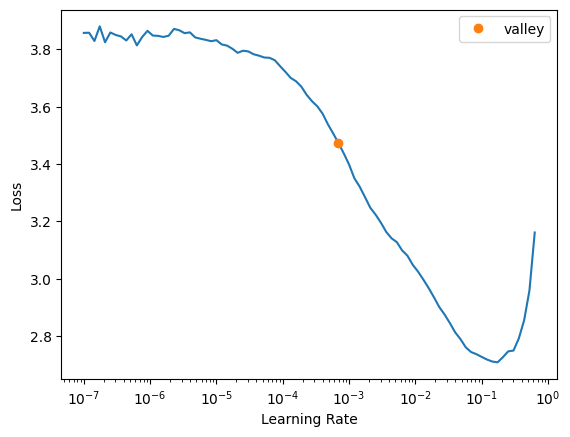

In [ ]:
# Подбираем learning_rate
vl.lr_find()

In [10]:
vl.fit_one_cycle(10, 0.0008)

epoch,train_loss,valid_loss,accuracy,time
0,2.433391,1.524570,0.522127,51:30
1,1.866249,1.407504,0.578416,51:10
2,1.511305,1.280627,0.598991,51:33
3,1.208320,1.183944,0.610637,52:49
4,1.042369,1.134940,0.626941,52:09
5,0.900353,1.099184,0.643245,52:05
6,0.806566,1.089885,0.636258,52:15
7,0.706147,1.089504,0.642081,52:26
8,0.631720,1.075797,0.638975,52:43
9,0.651480,1.084522,0.643634,52:26


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
vl.fit_one_cycle(30, 0.0007)

epoch,train_loss,valid_loss,accuracy,time
0,0.021905,1.437977,0.683536,01:30
1,0.021522,1.458348,0.677771,01:32
2,0.026997,1.509519,0.680974,01:31
3,0.062338,1.753814,0.642537,01:30
4,0.152358,2.225198,0.561179,01:30
5,0.288034,1.803749,0.597694,01:31
6,0.298860,1.670285,0.604741,01:31
7,0.270742,1.601030,0.617553,01:30
8,0.236891,1.768242,0.613709,01:30
9,0.212258,1.608948,0.616272,01:30


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


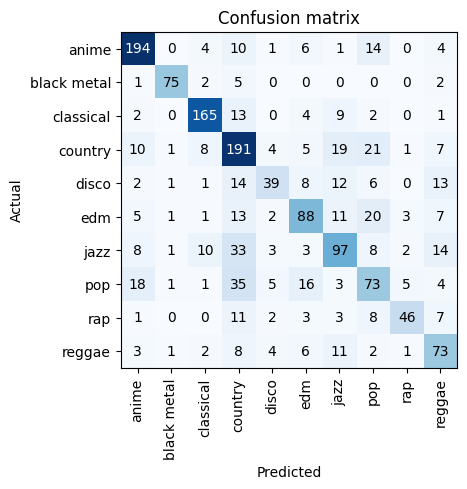

In [ ]:
interp = ClassificationInterpretation.from_learner(vl)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

       anime       0.80      0.83      0.81       234
 black metal       0.93      0.88      0.90        85
   classical       0.85      0.84      0.85       196
     country       0.57      0.72      0.64       267
       disco       0.65      0.41      0.50        96
         edm       0.63      0.58      0.61       151
        jazz       0.58      0.54      0.56       179
         pop       0.47      0.45      0.46       161
         rap       0.79      0.57      0.66        81
      reggae       0.55      0.66      0.60       111

    accuracy                           0.67      1561
   macro avg       0.68      0.65      0.66      1561
weighted avg       0.67      0.67      0.66      1561



In [ ]:
# Второй способ обучения
vl.fine_tune(20, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.701704,1.194200,0.611787,01:27


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,0.634863,1.168741,0.628443,01:31
1,0.572475,1.141413,0.639334,01:30
2,0.540659,1.147839,0.643818,01:30
3,0.501221,1.134346,0.646381,01:30
4,0.454052,1.144090,0.654709,01:29
5,0.406638,1.173978,0.655349,01:30
6,0.368748,1.180773,0.663677,01:30
7,0.324767,1.190192,0.663037,01:30
8,0.274798,1.207585,0.664958,01:30
9,0.235616,1.238235,0.665599,01:30


In [ ]:
interp = ClassificationInterpretation.from_learner(vl)
interp.print_classification_report()

              precision    recall  f1-score   support

       anime       0.79      0.80      0.79       234
 black metal       0.83      0.94      0.88        85
   classical       0.85      0.87      0.86       196
     country       0.63      0.78      0.70       267
       disco       0.54      0.40      0.46        96
         edm       0.58      0.54      0.56       151
        jazz       0.64      0.54      0.59       179
         pop       0.46      0.47      0.47       161
         rap       0.82      0.56      0.66        81
      reggae       0.58      0.58      0.58       111

    accuracy                           0.67      1561
   macro avg       0.67      0.65      0.65      1561
weighted avg       0.67      0.67      0.67      1561



## Выводы:

Базовая модель метода ближайших соседей показала результат `accuracy=0.63`, возможно был вариант как-то повысить это значение, но не хватило ресурсов и знаний.
Результаты применения нейронной сети также довольно скромные, видно, что модель допускает ошибки, так, жанр `country` часто относит к `pop`, `jazz`, `edm` или `disco`. Приэтом, жанр `country`, наряду с жанром `anime`, является самым "узнаваемым" моделью. Понимаю, что не получилось полностью раскрыть возможности нейронной сети, чтобы добиться лучшей метрики, я так и не поняла и не уловила настроение google colab, так как использовать GPU у меня получилось лишь пару раз, и в эти два раза как раз получена максимальная метрика `0.67`.  